In [92]:
#pip install numpy==1.18.5

In [93]:
#pip install yfinance

In [94]:
import pandas as pd
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import yfinance as yf
import numpy as np
import joblib
import os
import tensorflow as tf
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from xgboost import plot_importance
#ParameterGrid for Gridsearch without CV


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR



warnings.filterwarnings("ignore")

In [95]:
print(np.__version__)

1.23.5


## UDFs

In [96]:
def feature_engineering(data, SPY, predictions=np.array([None])):
    
    """
    The function applies future engineering to the data in order to get more information out of the inserted data. 
    The commented code below is used when we are trying to append the predictions of the model as a new input feature to train it again. In this case it performed slightli better, however depending on the parameter optimization this gain can be vanished. 
    """
    assert type(data) == pd.core.frame.DataFrame, "data musst be a dataframe"
    assert type(SPY) == pd.core.series.Series, "SPY musst be a dataframe"
    assert type(predictions) == np.ndarray, "predictions musst be an array"
       
    #if predictions.any() ==  True:
        #data = yf.download("AAPL", start="2001-11-30")
        #SPY = yf.download("SPY", start="2001-11-30")["Close"]
        #data = features(data, SPY)
        #print(data.shape)
        #data["Predictions"] = predictions
        #data["Close"] = data["Close_y"]
        #data.drop("Close_y",1,  inplace=True)
        #data.dropna(0, inplace=True)
    #else:
    print("No model yet")
    data = features(data, SPY)
    return data

def features(data, SPY):
    
    for i in [2, 3, 4, 5, 6, 7]:
                            
        # Rolling Mean
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).mean()
        data[f"Volume{i}"] = data["Volume"].rolling(i).mean()
        
        # Rolling Standart Deviation                               
        data[f"Low_std{i}"] = data["Low"].rolling(i).std()
        data[f"High_std{i}"] = data["High"].rolling(i).std()
        data[f"Adj_CLose{i}"] = data["Adj Close"].rolling(i).std()
        
        # Stock return for the next i days
        data[f"Close{i}"] = data["Close"].shift(i)
        
        # Rolling Maximum and Minimum
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).max()
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).min()
        
        # Rolling Quantile
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).quantile(1)
    
    
    
    data["SPY"] = SPY
    #Decoding the time of the year
    data["Day"] = data.index.day
    data["Month"] = data.index.month
    data["Year"] = data.index.year
    data["day_year"] = data.index.day_of_year
    data["Weekday"] = data.index.weekday
                  
    #Upper and Lower shade
    data["Upper_Shape"] = data["High"]-np.maximum(data["Open"], data["Close"])
    data["Lower_Shape"] = np.minimum(data["Open"], data["Close"])-data["Low"]
    
                                                                            
    data["Close_y"] = data["Close"]
    data.drop("Close",1,  inplace=True)
    data.dropna(0, inplace=True)
    return data

In [97]:
def windowing(train, val, WINDOW, PREDICTION_SCOPE):
    
    """
    Divides the inserted data into a list of lists. Where the shape of the data becomes and additional axe, which is time.
    Basically gets as an input shape of (X, Y) and gets returned a list which contains 3 dimensions (X, Z, Y) being Z, time.
    
    Input:
        - Train Set
        - Validation Set
        - WINDOW: the desired window
        - PREDICTION_SCOPE: The period in the future you want to analyze
        
    Output:
        - X_train: Explanatory variables for training set
        - y_train: Target variable training set
        - X_test: Explanatory variables for validation set
        - y_test:  Target variable validation set
    """  
    
    assert type(train) == np.ndarray, "train musst be passed as an array"
    assert type(val) == np.ndarray, "validation musst be passed as an array"
    assert type(WINDOW) == int, "Window musst be an integer"
    assert type(PREDICTION_SCOPE) == int, "Prediction scope musst be an integer"
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(len(train)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(train[i:i+WINDOW, :-1]), np.array(train[i+WINDOW+PREDICTION_SCOPE, -1])
        X_train.append(X)
        y_train.append(y)

    for i in range(len(val)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(val[i:i+WINDOW, :-1]), np.array(val[i+WINDOW+PREDICTION_SCOPE, -1])
        X_test.append(X)
        y_test.append(y)
        
    return X_train, y_train, X_test, y_test
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def train_test_split(data, WINDOW):
    """
    Divides the training set into train and validation set depending on the percentage indicated.
    Note this could also be done through the sklearn traintestsplit() function.
    
    Input:
        - The data to be splitted (stock data in this case)
        - The size of the window used that will be taken as an input in order to predict the t+1
        
    Output:
        - Train/Validation Set
        - Test Set
    """
    
    assert type(data) == pd.core.frame.DataFrame, "data musst be a dataframe"
    assert type(WINDOW) == int, "Window musst be an integer"
    
    train = stock_prices.iloc[:-WINDOW]
    test = stock_prices.iloc[-WINDOW:]
    
    return train, test
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def train_validation_split(train, percentage):
    """
    Divides the training set into train and validation set depending on the percentage indicated
    """
    assert type(train) == pd.core.frame.DataFrame, "train musst be a dataframe"
    assert type(percentage) == float, "percentage musst be a float"
    
    train_set = np.array(train.iloc[:int(len(train)*percentage)])
    validation_set = np.array(train.iloc[int(len(train)*percentage):])
    
    
    return train_set, validation_set
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def plotting(y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE):
    
    """This function returns a graph where:
        - Validation Set
        - Test Set
        - Future Prediction
        - Upper Bound
        - Lower Bound
    """
    assert type(WINDOW) == int, "Window musst be an integer"
    assert type(PREDICTION_SCOPE) == int, "Preiction scope musst be an integer"
    
    ploting_pred = [y_test[-1], pred_test]
    ploting_test = [y_val[-1]]+list(y_test)

    time = (len(y_val)-1)+(len(ploting_test)-1)+(len(ploting_pred)-1)

    test_time_init = time-(len(ploting_test)-1)-(len(ploting_pred)-1)
    test_time_end = time-(len(ploting_pred)-1)+1

    pred_time_init = time-(len(ploting_pred)-1)
    pred_time_end = time+1

    x_ticks = list(stock_prices.index[-time:])+[stock_prices.index[-1]+timedelta(PREDICTION_SCOPE+1)]

    values_for_bounds = list(y_val)+list(y_test)+list(pred_test)
    upper_band = values_for_bounds+mae
    lower_band = values_for_bounds-mae
    
    print(f"For used windowed data: {WINDOW}")
    print(f"Prediction scope for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days")
    print(f"The predicted price is {str(round(ploting_pred[-1][0],2))}$")
    print(f"With a spread of MAE is {round(mae,2)}")
    print()
    
    plt.figure(figsize=(16, 8))

    plt.plot(list(range(test_time_init, test_time_end)),ploting_test, marker="$m$", color="orange")
    plt.plot(list(range(pred_time_init, pred_time_end)),ploting_pred,marker="$m$", color="red")
    plt.plot(y_val, marker="$m$")

    plt.plot(upper_band, color="grey", alpha=.3)
    plt.plot(lower_band, color="grey", alpha=.3)

    plt.fill_between(list(range(0, time+1)),upper_band, lower_band, color="grey", alpha=.1)

    plt.xticks(list(range(0-1, time)), x_ticks, rotation=45)
    plt.text(time-0.5, ploting_pred[-1]+2, str(round(ploting_pred[-1][0],2))+"$", size=11, color='red')
    plt.title(f"Target price for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days, with used past data of {WINDOW} days and a MAE of {round(mae,2)}", size=15)
    plt.legend(["Testing Set (input for Prediction)", "Prediction", "Validation"])
    plt.show()
    
    print()
    print("-----------------------------------------------------------------------------")
    print()
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def inverse_transformation(X, y, y_hat):
    
    """
    This function serves to inverse the rescaled data. 
    There are two ways in which this can happen:
        - There could be the conversion for the validation data to see it on the plotting.
        - There could be the conversion for the testing data, to see it plotted.
    """
    assert type(X) == np.ndarray, "X musst be an array"
    assert type(y) == np.ndarray, "y musst be an array"
    
    if X.shape[1]>1:
        new_X = []

        for i in range(len(X)):
            new_X.append(X[i][0])
            
        new_X = np.array(new_X)
        y = np.expand_dims(y, 1)
        
        new_X = pd.DataFrame(new_X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)

        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))
        
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        
    else:       
        X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
        
        new_X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)
        y_hat = pd.concat((y, y_hat))
        y_hat.index = range(len(y_hat))
        
        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))
        
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        
    return real_val, pred_val
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------    
def window_optimization(plots):
    
    """Returns the key that contains the most optimal window (respect to mae) for t+1"""
    
    assert type(plots) == dict, "plots musst be a dictionary"
    
    rank = []
    m = []
    for i in plots.keys():
        if not rank:
            rank.append(plots[i])
            m.append(i)
        elif plots[i][3]<rank[0][3]:
            rank.clear()
            m.clear()
            rank.append(plots[i])
            m.append(i)
            
    return rank, m

In [98]:
def window_optimization(plots):
    
    """Returns the key that contains the most optimal window (respect to mae) for t+1"""
    
    assert type(plots) == dict, "plots musst be a dictionary"
    
    rank = []
    m = []
    for i in plots.keys():
        if not rank:
            rank.append(plots[i])
            m.append(i)
        elif plots[i][3]<rank[0][3]:
            rank.clear()
            m.clear()
            rank.append(plots[i])
            m.append(i)
            
    return rank, m

In [99]:
def predictions(mae_lstm, mae_xgboost, prediction_xgb, prediction_lstm):
    if len(prediction_xgb) > 0 and len(prediction_lstm) > 0:
        prediction = (1-(mae_xgboost/(mae_lstm+mae_xgboost)))*prediction_xgb+(1-(mae_lstm/(mae_lstm+mae_xgboost)))*prediction_lstm
        return prediction
    else:
        print("Error: One or more input arrays is empty")
        return []


In [100]:
def sp500_log_rets(tickers):
    
    """Returns the logarithmic returns from the SP500"""
    
    stock_prices = yf.download(tickers, start="2015-11-30", end="2021-11-30")["Close"]
    log_rets = {}
    for index, ticker in enumerate(tickers):
        log_rets[ticker] = np.log(stock_prices[ticker]/stock_prices[ticker].shift(1))
    return log_rets

In [101]:
def annualized_rets(r):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(255/n_periods)-1

In [102]:
def log_returns(train, percentage):
    """
    Returns log returns
    """
    
    train_logrets = np.log(train.iloc[:int(len(train)*percentage)]["Close_y"]/train.iloc[:int(len(train)*percentage)]["Close_y"].shift(1))
    val_logrets = np.log(train.iloc[int(len(train)*percentage):]["Close_y"]/train.iloc[int(len(train)*percentage):]["Close_y"].shift(1))
    return train_logrets, val_logrets

In [103]:
def xgb_model(X_train, y_train, X_val, y_val, plotting=False):

    """
    Trains a preoptimized XGBoost model and returns the Mean Absolute Error an a plot if needed
    """     
    xgb_model = xgb.XGBRegressor(gamma=1, n_estimators=200)
    xgb_model.fit(X_train,y_train)
    
    pred_val = xgb_model.predict(X_val)
    mae = mean_absolute_error(y_val, pred_val)

    if plotting == True:
        
        plt.figure(figsize=(15, 6))
        
        sns.set_theme(style="white")
        sns.lineplot(range(len(y_val)), y_val, color="grey", alpha=.4)
        sns.lineplot(range(len(y_val)),pred_val, color="red")

        plt.xlabel("Time")
        plt.ylabel("AAPL stock price")
        plt.title(f"The MAE for this period is: {round(mae, 3)}")
    
    return  mae, xgb_model

In [104]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

def lstm_model(X_train, y_train, X_val, y_val, EPOCH,BATCH_SIZE,CALLBACK,  plotting=False):
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get("val_mae")<CALLBACK):
                print("\n Accuracy % so cancelling training")
                self.model.stop_training=True

    callbacks = myCallback()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 0.228 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.228, momentum =.85)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics="mae")
    history = model.fit(X_train, y_train,batch_size=BATCH_SIZE, epochs=EPOCH,callbacks=[callbacks],  validation_data=[X_val, y_val], verbose=1)
    
    if plotting == True:
        plt.figure(figsize=(18, 6))

        lrs = 1e-5 * (10 ** (np.arange(len(history.history["loss"])) / 20))
        plt.semilogx(lrs, history.history["loss"])
        plt.xticks(size=14)
        plt.show()
    
    return model

## Data Overview

In [105]:
stock_prices = yf.download("000300.SS")
SPY = yf.download("000001.SS", start="2005-01-01")["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [106]:
type(SPY)

pandas.core.series.Series

In [107]:
close = stock_prices["Close"]

In [108]:
stock_prices.drop("Close",1, inplace=True)
stock_prices["Close"] = close

In [109]:
stock_prices.head(20)

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2021-03-11,5024.560059,5138.410156,5020.580078,5128.220215,189600,5128.220215
2021-03-12,5153.669922,5153.669922,5086.819824,5146.379883,201000,5146.379883
2021-03-15,5116.120117,5120.879883,4992.399902,5035.540039,204200,5035.540039
2021-03-16,5054.410156,5084.310059,5009.950195,5079.359863,161400,5079.359863
2021-03-17,5062.770020,5123.549805,5020.129883,5100.859863,149200,5100.859863
2021-03-18,5114.589844,5160.459961,5111.129883,5141.770020,142900,5141.770020
2021-03-19,5068.529785,5089.919922,4980.759766,5007.089844,164200,5007.089844
2021-03-22,5008.399902,5071.339844,4996.540039,5057.149902,167400,5057.149902
2021-03-23,5057.060059,5064.020020,4966.529785,5009.250000,158000,5009.250000


In [110]:
rets = np.log(stock_prices["Close"]/stock_prices["Close"].shift(1))
vol = np.array(stock_prices["2019-01-01":"2022-01-27"]["Volume"])

In [111]:
stock_prices.describe()

,Open,High,Low,Adj Close,Volume,Close
count,517.000000,517.000000,517.000000,517.000000,5.170000e+02,517.000000
mean,4466.214609,4497.173821,4433.684071,4467.211177,2.872573e+05,4467.211177
std,486.384222,487.221819,482.894906,486.596202,3.322034e+06,486.596202
min,3504.510010,3553.389893,3495.949951,3508.699951,6.480000e+04,3508.699951
25%,4050.590088,4077.600098,4026.449951,4043.840088,1.161000e+05,4043.840088
50%,4313.359863,4344.859863,4269.970215,4309.040039,1.385000e+05,4309.040039
75%,4924.290039,4949.229980,4891.799805,4922.100098,1.601000e+05,4922.100098
max,5348.339844,5378.479980,5308.740234,5341.680176,7.567172e+07,5341.680176


In [112]:
tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "SPY"]

In [113]:
log_rets = sp500_log_rets(tickers)

[*********************100%***********************]  5 of 5 completed


In [114]:
#Annual rets for the selected tickers
ann_rets = {}
for ticker in log_rets.keys():
    ann_rets[ticker] = str(round(annualized_rets(log_rets[ticker])*100,2))+"%"
ann_rets

{'AAPL': '27.29%',
 'MSFT': '31.17%',
 'TSLA': '45.67%',
 'AMZN': '27.05%',
 'SPY': '12.54%'}

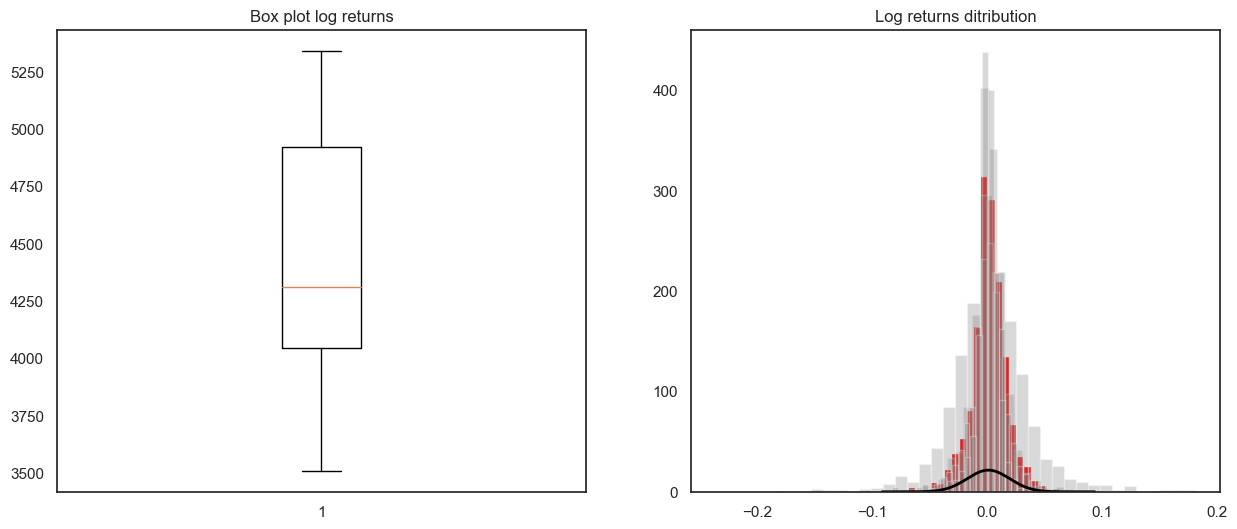

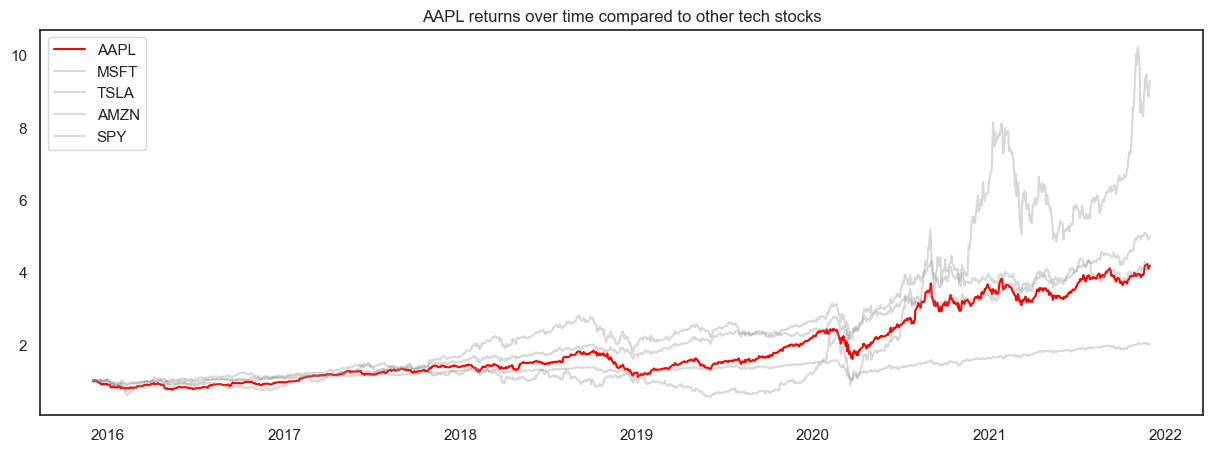

In [115]:
import scipy.stats as st

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        mu = np.mean(log_rets["AAPL"])
        sigma = np.std(log_rets["AAPL"])
        x = np.linspace(mu -5*sigma, mu +5*sigma, 1000)
        pdf = st.norm.pdf(x, mu, sigma)
        ax[1].plot(x, pdf, lw = 2, color = "black")
        ax[1].hist(log_rets[i], bins=40, color = "red")
        ax[0].boxplot(stock_prices["Close"])
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")
    else:
        ax[1].hist(log_rets[i], bins=40, color = "grey", alpha=.3)
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")


fig,ax = plt.subplots(figsize=(15,5))
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax.plot((1+log_rets[i]).cumprod(), color="red")

    else:
        ax.plot((1+log_rets[i]).cumprod(), color="grey", alpha=.3)

ax.legend(tickers)
ax.set_title("AAPL returns over time compared to other tech stocks")
#ax.text(18970, 4, ann_rets["AAPL"], size=9, color='red')

plt.show()

# Simple Regressions

In [116]:
PERCENTAGE = .995
WINDOW = 2
PREDICTION_SCOPE = 0

In [117]:
stock_prices = feature_engineering(stock_prices, SPY)

No model yet


In [118]:
train_reg, test_reg = train_test_split(stock_prices, WINDOW)
train_split_reg, validation_split_reg = train_validation_split(train_reg, PERCENTAGE)

In [119]:
print(train_reg.shape)
print(test_reg.shape)

(508, 50)
(2, 50)


In [120]:
train_set_reg = np.array(train_split_reg)
validation_set_reg = np.array(validation_split_reg)

In [121]:
X_train_reg, y_train_reg, X_val_reg, y_val_reg = windowing(train_set_reg, validation_set_reg, WINDOW, PREDICTION_SCOPE)

In [122]:
#Reshaping the Data

X_train_reg = np.array(X_train_reg)
y_train_reg = np.array(y_train_reg)


X_val_reg = np.array(X_val_reg)
y_val_reg = np.array(y_val_reg)



X_train_reg = X_train_reg.reshape(X_train_reg.shape[0], -1)
X_val_reg = X_val_reg.reshape(X_val_reg.shape[0], -1)

In [123]:
print(y_train_reg.shape)
print(X_train_reg.shape)
print(X_val_reg.shape)
print(y_val_reg.shape)

(503,)
(503, 98)
(1, 98)
(1,)


In [124]:
X_test_reg = np.array(test_reg.iloc[:, :-1])
y_test_reg = np.array(test_reg.iloc[:, -1])

print(X_test_reg.shape)

(2, 49)


In [125]:
X_test_reg = X_test_reg.reshape(1, -1)

print(X_test_reg.shape)

(1, 98)


### Linear Regression

In [126]:
lr = LinearRegression()

lr.fit(X_train_reg, y_train_reg)

y_hat_lr= lr.predict(X_val_reg)

mae_lr = mean_absolute_error(y_val_reg, y_hat_lr)

print("MSE: {}".format(np.mean((y_hat_lr-y_val_reg)**2)))
print("MAE: {}".format(mae_lr))

MSE: 3377.9734912142117
MAE: 58.12033629646521


### Random Forest Regressor

In [127]:
rf = RandomForestRegressor()

rf.fit(X_train_reg, y_train_reg)

y_hat_rf= rf.predict(X_val_reg)

mae_rf= mean_absolute_error(y_val_reg, y_hat_rf)

print("MSE: {}".format(np.mean((y_hat_rf-y_val_reg)**2)))
print("MAE: {}".format(mae_rf))

MSE: 3915.381001170907
MAE: 62.573005371093586


In [128]:
y_hat_rf = np.ravel(y_hat_rf)
y_hat_lr = np.ravel(y_hat_lr)
y_val_reg = np.ravel(y_val_reg)

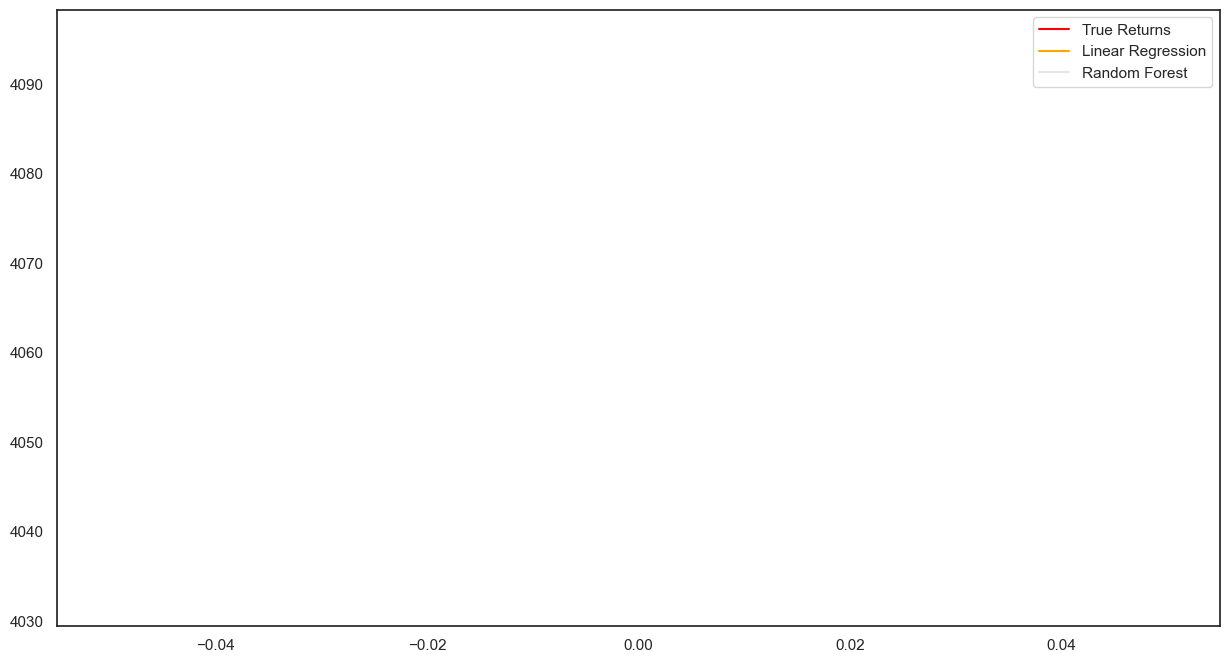

In [129]:
fig,ax = plt.subplots(figsize=(15,8))

ax.plot(y_val_reg, color="red")
ax.plot(y_hat_lr, color="orange")
ax.plot(y_hat_rf, color="grey", alpha=.2)

ax.legend(["True Returns", "Linear Regression", "Random Forest"])

In [130]:
pred_test_lr = lr.predict(X_test_reg)

For used windowed data: 2
Prediction scope for date 2023-04-26 00:00:00 / 1 days
The predicted price is 7234.7$
With a spread of MAE is 58.12



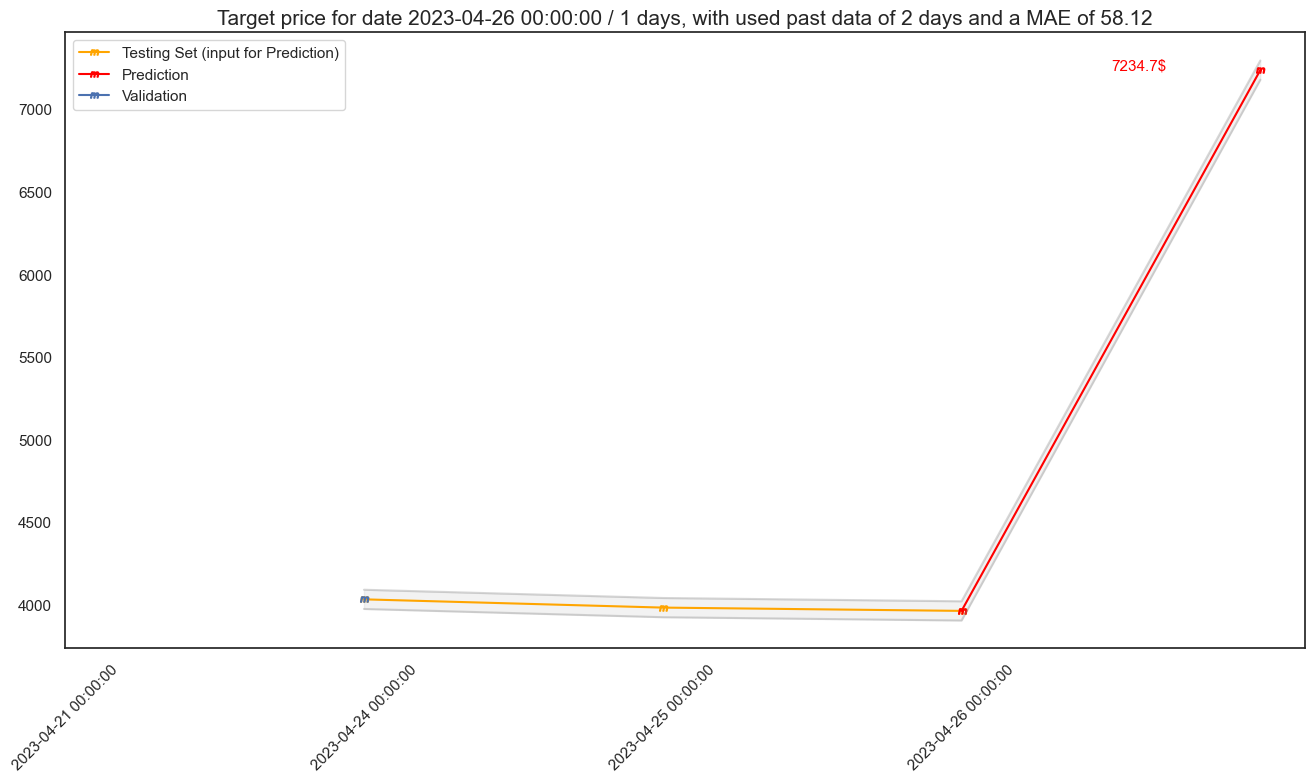


-----------------------------------------------------------------------------



In [131]:
plotting(y_val_reg, y_test_reg, pred_test_lr, mae_lr, WINDOW, PREDICTION_SCOPE)

# XGBoost

XGBoost, is one of the most highly used supervised ML algorithms nowadays.

The algorithm uses a more optimized way to implement a tree based algorithm.

The methodology followed by this algorithm is the following. XGBoost uses a Greedy algorithm for the building of its tree, meaning it uses a simple intuitive way to optimze the algorithm. This is done by making a prediction (which acts as a threshols), before starting to evaluate the rest of the observations, which then turn into other thresholds, and so on.

This methods enables it to manage huge amount of data very quickly.

In the case of regression, it basically build up a Regression Tree through the residuals of each data point to the initial prediction. Then we split the data into portions and compare one to another and see which one is better at splitting the residuals into clusters of similar values.

For more insights into how this algorithm works, check out this video from [StatQuest](https://www.youtube.com/watch?v=OtD8wVaFm6E&t=649s)


## Feature Engineering

We will firt make the analysis forecasting 1 period ahead

In [132]:
stock_prices = yf.download("AAPL", start="2001-11-30")

[*********************100%***********************]  1 of 1 completed


In [133]:
PERCENTAGE = .995
WINDOW = 2
PREDICTION_SCOPE = 0

In [134]:
stock_prices = feature_engineering(stock_prices, SPY)

No model yet


In [135]:
train, test = train_test_split(stock_prices, WINDOW)
train_set, validation_set = train_validation_split(train, PERCENTAGE)

print(f"train_set shape: {train_set.shape}")
print(f"validation_set shape: {validation_set.shape}")
print(f"test shape: {test.shape}")

train_set shape: (4275, 50)
validation_set shape: (22, 50)
test shape: (2, 50)


Here are some functions that pretend to ease us the work while applying the same algorithm on different period forecasts

In [136]:
X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

#Convert the returned list into arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (4273, 2, 49)
y_train shape: (4273,)
X_val shape: (20, 2, 49)
y_val shape: (20,)


In [137]:
#Reshaping the Data

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (4273, 98)
X_val shape: (20, 98)


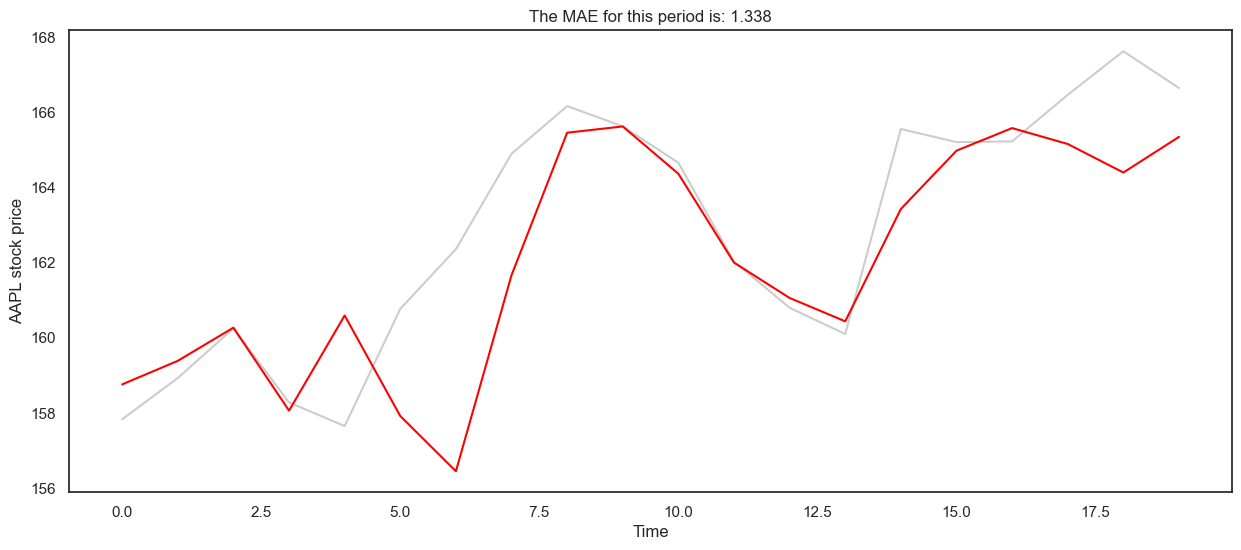

In [138]:
mae, xgb_model = xgb_model(X_train, y_train, X_val, y_val, plotting=True)

<Figure size 1600x1600 with 0 Axes>

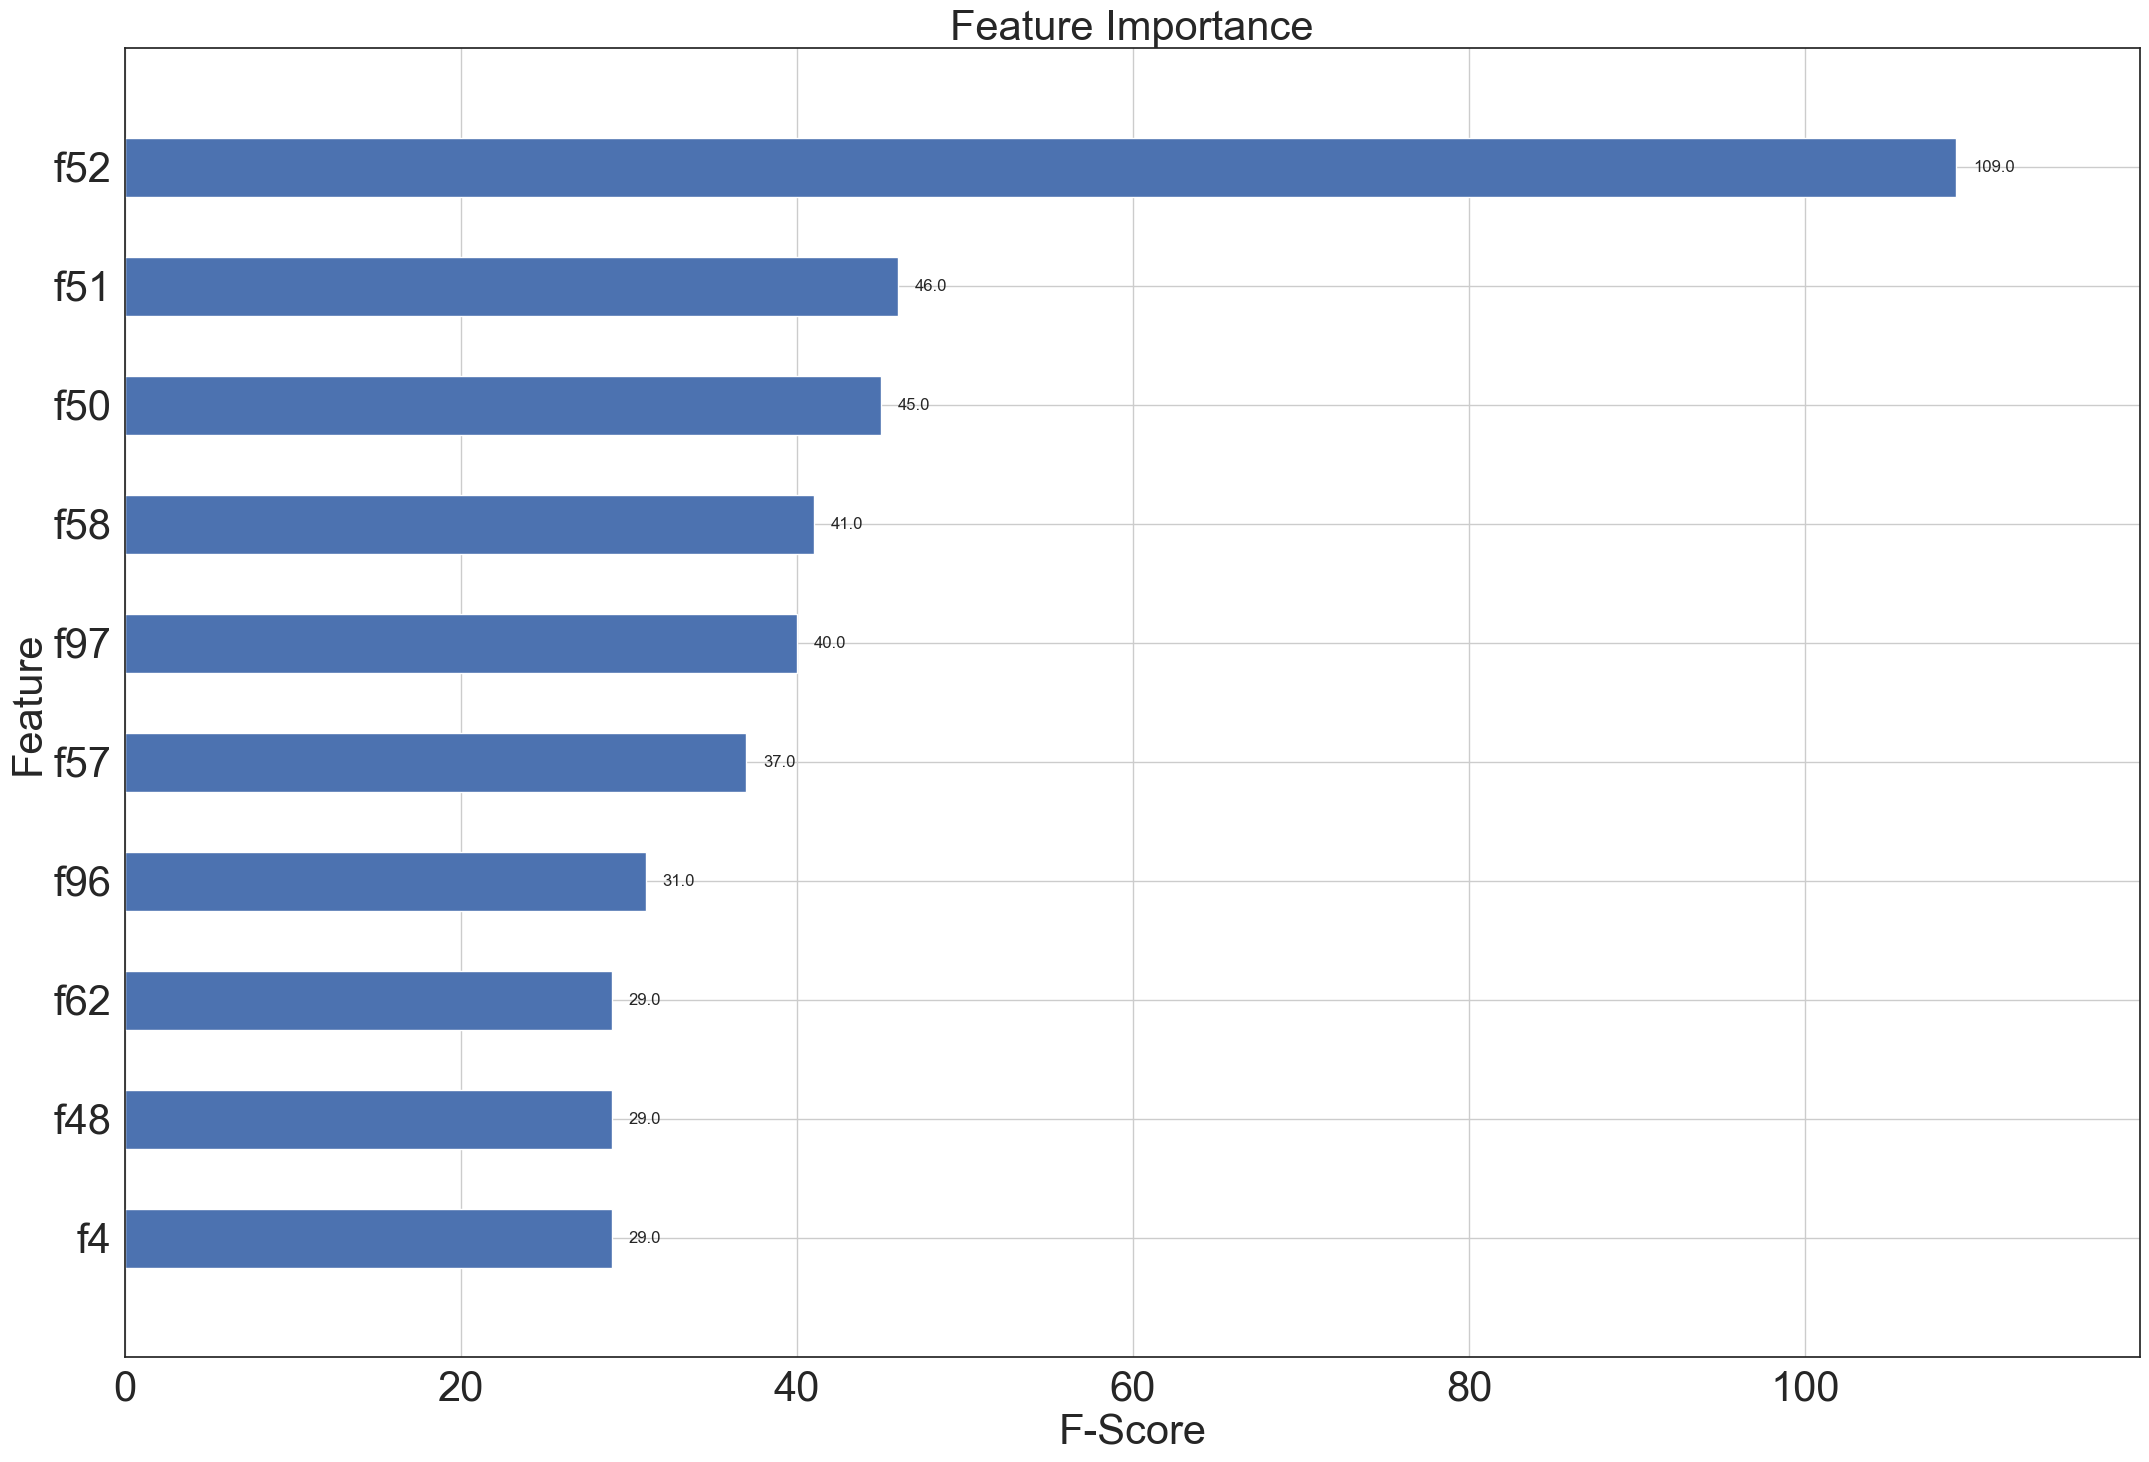

In [139]:
plt.figure(figsize=(16, 16))
fig, ax = plt.subplots(1, 1, figsize=(26, 17))

plot_importance(xgb_model,ax=ax,height=0.5, max_num_features=10)
ax.set_title("Feature Importance", size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.ylabel("Feature", size=30)
plt.xlabel("F-Score", size=30)
plt.show()

## Add the predictions (if needed)

In [140]:
#try:
    #y_hat_train = np.expand_dims(xgb_model.predict(X_train), 1)
    #array = np.empty((stock_prices.shape[0]-y_hat_train.shape[0], 1))
    #array[:] = np.nan
    #predictions = np.concatenate((array, y_hat_train))
#except NameError:
    #print("No Model")
    
    
#new_stock_prices = feature_engineering(stock_prices, SPY, predictions=predictions)


#train, test = train_test_split(new_stock_prices, WINDOW)

#train_set, validation_set = train_validation_split(train, PERCENTAGE)
#X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

#Reshaping the data
#X_train = np.array(X_train)
#y_train = np.array(y_train)

#X_val = np.array(X_val)
#y_val = np.array(y_val)

#X_train = X_train.reshape(X_train.shape[0], -1)
#X_val = X_val.reshape(X_val.shape[0], -1)


#new_mae, new_xgb_model = xgb_model(X_train, y_train, X_val, y_val, plotting=True)

#print(new_mae)

## Evaluation on the Test Set

In [141]:
X_test = np.array(test.iloc[:, :-1])
y_test = np.array(test.iloc[:, -1])
X_test = X_test.reshape(1, -1)

print(f"X_test shape: {X_test.shape}")

X_test shape: (1, 98)


In [142]:
#Apply the xgboost model on the Test Data

pred_test_xgb = xgb_model.predict(X_test)

For used windowed data: 2
Prediction scope for date 2023-04-25 00:00:00 / 1 days
The predicted price is 163.61$
With a spread of MAE is 1.34



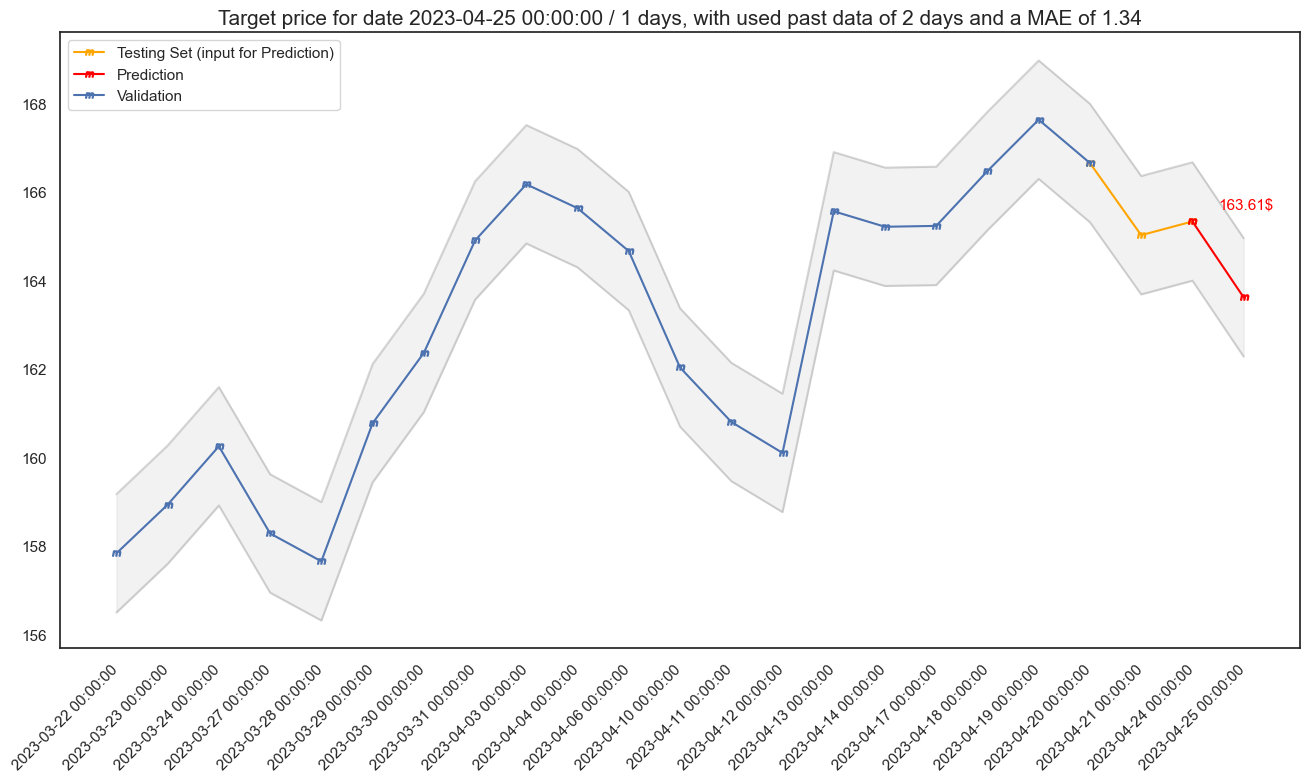


-----------------------------------------------------------------------------



In [143]:
plotting(y_val, y_test, pred_test_xgb, mae, WINDOW, PREDICTION_SCOPE)

## Saving the XGBoost parameters

In [144]:
#joblib.dump(xgb_model, "XGBoost.pkl")

## MULTIPLE EVALUATIONS

In [145]:
plots = {}


for window in [1, 2, 3, 4, 5, 6, 7, 10, 20, 25, 30, 35]:
    
    for percentage in [.92, .95, .97, .98, .99, .995]:

        WINDOW = window
        pred_scope = 0
        PREDICTION_SCOPE = pred_scope
        PERCENTAGE = percentage

        train = stock_prices.iloc[:int(len(stock_prices))-WINDOW]
        test = stock_prices.iloc[-WINDOW:]
        
        train_set, validation_set = train_validation_split(train, PERCENTAGE)

        X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        X_val = np.array(X_val)
        y_val = np.array(y_val)

        X_test = np.array(test.iloc[:, :-1])
        y_test = np.array(test.iloc[:, -1])

        X_train = X_train.reshape(X_train.shape[0], -1)
        try:
            X_val = X_val.reshape(X_val.shape[0], -1)
            X_test = X_test.reshape(1, -1)
        except ValueError:
            break

        xgb_model = xgb.XGBRegressor(gamma=1)
        xgb_model.fit(X_train, y_train)

        pred_val = xgb_model.predict(X_val)

        mae = mean_absolute_error(y_val, pred_val)

        pred_test = xgb_model.predict(X_test)
        plotii= [y_test[-1], pred_test]

        plots[str(window)+str(pred_scope)] = [y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE, PERCENTAGE]
    

In [146]:
print()
print(plots["20"])
print("-----------------------------------------------------------------------------------------------------------------")
print(plots["10"])


[array([157.83000183, 158.92999268, 160.25      , 158.27999878,
       157.6499939 , 160.77000427, 162.36000061, 164.8999939 ,
       166.16999817, 165.63000488, 164.66000366, 162.02999878,
       160.80000305, 160.1000061 , 165.55999756, 165.21000671,
       165.22999573, 166.47000122, 167.63000488, 166.6499939 ]), array([165.02000427, 165.33000183]), array([163.61356], dtype=float32), 1.3375274658203125, 2, 0, 0.995]
-----------------------------------------------------------------------------------------------------------------
[array([157.83000183, 158.92999268, 160.25      , 158.27999878,
       157.6499939 , 160.77000427, 162.36000061, 164.8999939 ,
       166.16999817, 165.63000488, 164.66000366, 162.02999878,
       160.80000305, 160.1000061 , 165.55999756, 165.21000671,
       165.22999573, 166.47000122, 167.63000488, 166.6499939 ,
       165.02000427]), array([165.33000183]), array([162.10179], dtype=float32), 3.3377562023344494, 1, 0, 0.995]


In [147]:
window_optimization(plots)

([[array([157.83000183, 158.92999268, 160.25      , 158.27999878,
          157.6499939 , 160.77000427, 162.36000061, 164.8999939 ,
          166.16999817, 165.63000488, 164.66000366, 162.02999878,
          160.80000305, 160.1000061 , 165.55999756, 165.21000671]),
   array([165.22999573, 166.47000122, 167.63000488, 166.6499939 ,
          165.02000427, 165.33000183]),
   array([167.1564], dtype=float32),
   1.2649803161621094,
   6,
   0,
   0.995]],
 ['60'])

For used windowed data: 6
Prediction scope for date 2023-04-25 00:00:00 / 1 days
The predicted price is 167.16$
With a spread of MAE is 1.26



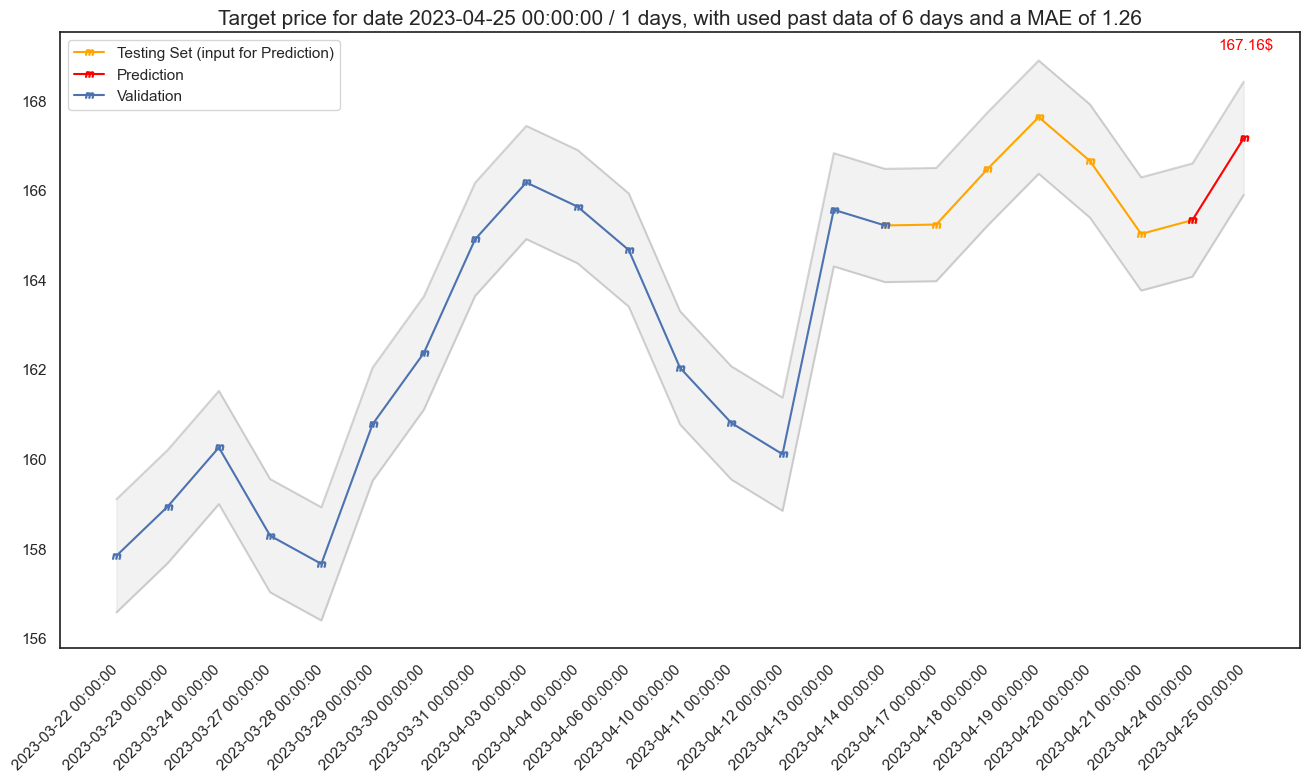


-----------------------------------------------------------------------------

For used windowed data: 7
Prediction scope for date 2023-04-25 00:00:00 / 1 days
The predicted price is 165.56$
With a spread of MAE is 1.74



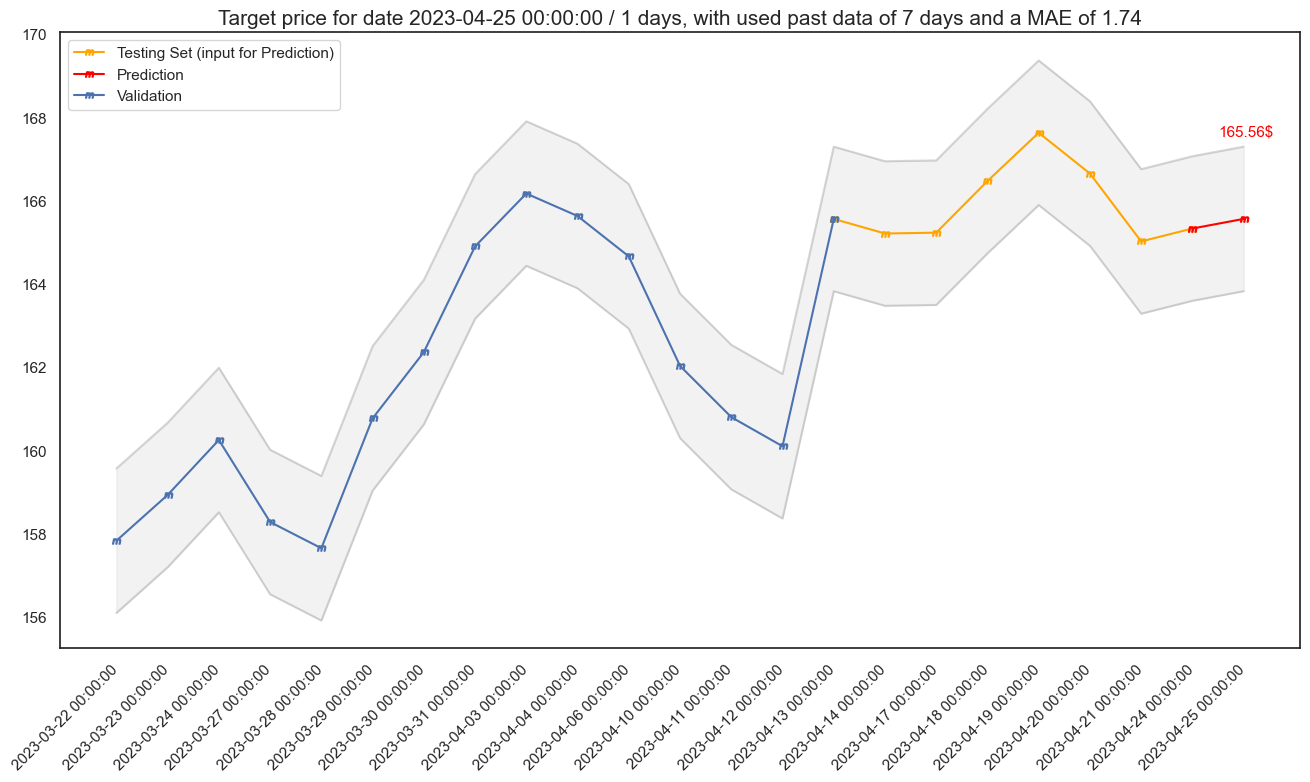


-----------------------------------------------------------------------------

For used windowed data: 10
Prediction scope for date 2023-04-25 00:00:00 / 1 days
The predicted price is 164.53$
With a spread of MAE is 2.95



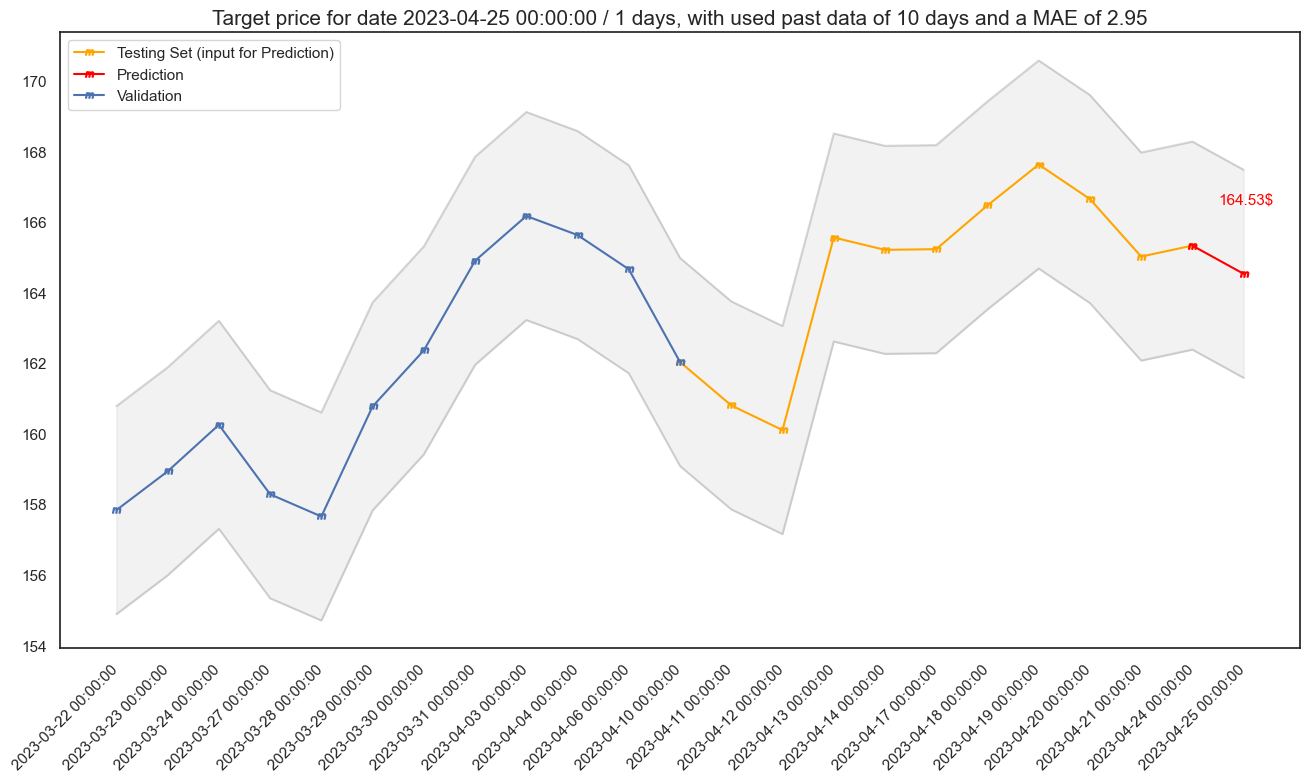


-----------------------------------------------------------------------------

For used windowed data: 20
Prediction scope for date 2023-04-25 00:00:00 / 1 days
The predicted price is 164.6$
With a spread of MAE is 2.26



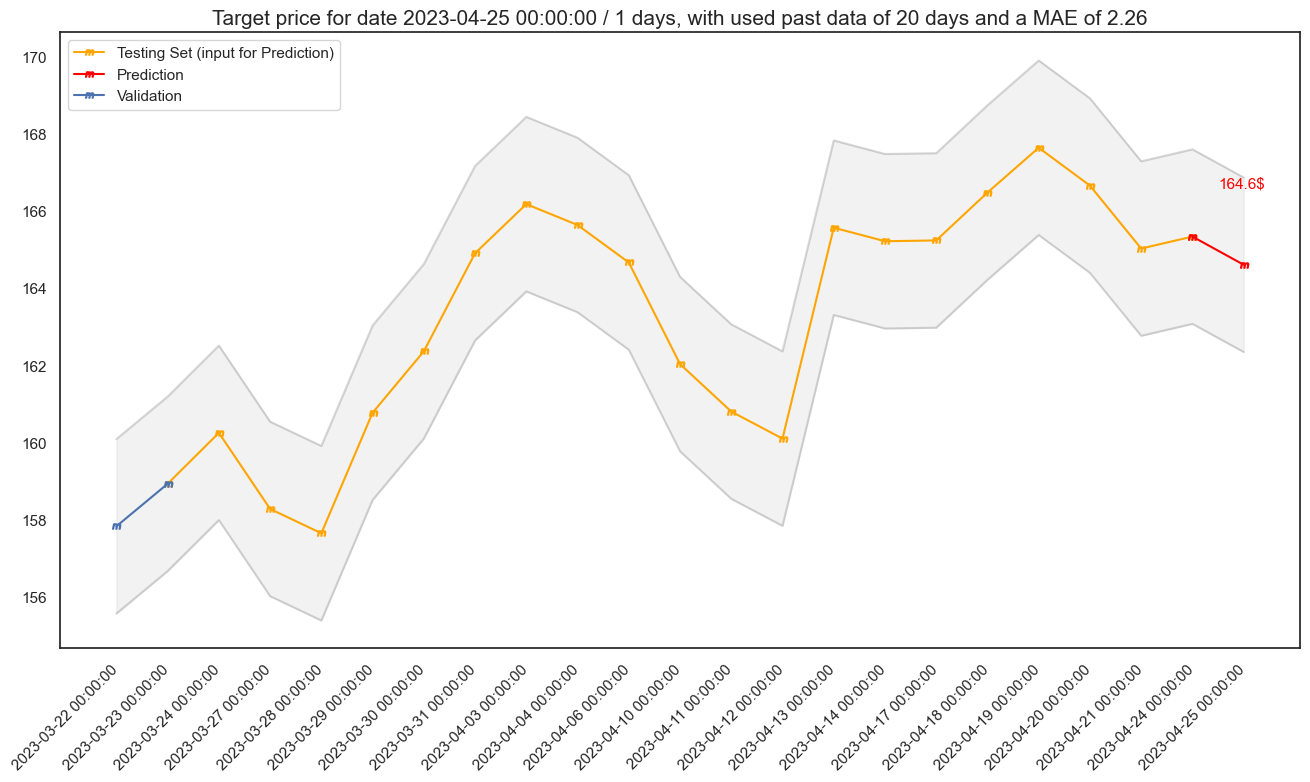


-----------------------------------------------------------------------------



In [148]:
for key in list(plots.keys())[5:9]:
    plotting(plots[key][0], plots[key][1], plots[key][2], plots[key][3], plots[key][4], plots[key][5])

# LSTM


Long Short Term Memory or LSTM is a type of Recurrent Neural Network, which instead fo only processing the information they recieve from the previous neuron and apply the activation function from scratch, they actually divide the neuron into three main parts from which to set up the input from the next layer of neurons: Learn, Unlearn and Retain gate.

The idea behind this method is to ensure that you are using the information given from previous data and the data returned from a neural that is in the same layer, to get the input for the next nuron.

This is specially usefull, when you are relying on the temporal distribution of the data, i.e. text, time series mainly.

In this work we will see how the LSTM is used for predicting the next period from Apple stock. Through hyperparameter tuning there was a need to define, similar to normal RNN, the input and hidden layer size, the batch_size, number of epochs and the rolling window size for the analysis.

The data ranging from 2001 till now, gained from the Yahoo Finance API, got splitted into a train, validation and test set to see how the model performed on different distributions. After that, the test set was settled to be the last width of the input data in order to predict the next period.

The parameters are showed below.

In [149]:
#Parameters for the LSTM
PERCENTAGE = .98 #Split train/val and test set
CALLBACK = .031 #Used to stop training the Network when the MAE from the validation set reached a perormance below 3.1%
BATCH_SIZE = 20 #Number of samples that will be propagated through the network. I chose almost a trading month
EPOCH = 50 #Settled to train the model
WINDOW_LSTM = 30 #The window used for the input data
PREDICTION_SCOPE = 0 #How many period to predict, being 0=1

In [150]:
train_lstm, test_lstm = train_test_split(stock_prices, WINDOW_LSTM)
train_split_lstm, validation_split_lstm = train_validation_split(train_lstm, PERCENTAGE)

train_split_lstm = np.array(train_split_lstm)
validation_split_lstm = np.array(validation_split_lstm)


## Rescaling to train the LSTM

In [151]:
scaler = MinMaxScaler()
scaler.fit(train_split_lstm)

train_scale_lstm = scaler.transform(train_split_lstm)
val_scale_lstm = scaler.transform(validation_split_lstm)
test_scale_lstm = scaler.transform(test_lstm)

print(train_scale_lstm.shape)
print(val_scale_lstm.shape)
print(test_scale_lstm.shape)

(4183, 50)
(86, 50)
(30, 50)


In [152]:
X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm = windowing(train_scale_lstm, val_scale_lstm, WINDOW_LSTM, PREDICTION_SCOPE)

In [153]:

X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)

X_val_lstm = np.array(X_val_lstm)
y_val_lstm = np.array(y_val_lstm)

X_test_lstm = np.array(test_scale_lstm[:, :-1])
y_test_lstm = np.array(test_scale_lstm[:, -1])

print(X_train_lstm.shape)
print(X_val_lstm.shape)
print(X_test_lstm.shape)

(4153, 30, 49)
(56, 30, 49)
(30, 49)


Epoch 1/50
208/208 [==============================] - 7s 18ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 0.0012 - val_mae: 0.0411
Epoch 2/50
208/208 [==============================] - 3s 14ms/step - loss: 1.6997e-04 - mae: 0.0122 - val_loss: 0.0011 - val_mae: 0.0394
Epoch 3/50
208/208 [==============================] - 3s 14ms/step - loss: 1.3305e-04 - mae: 0.0103 - val_loss: 0.0010 - val_mae: 0.0378
Epoch 4/50
208/208 [==============================] - 3s 14ms/step - loss: 1.2216e-04 - mae: 0.0098 - val_loss: 8.6586e-04 - val_mae: 0.0352
Epoch 5/50
208/208 [==============================] - 3s 14ms/step - loss: 1.3177e-04 - mae: 0.0106 - val_loss: 0.0013 - val_mae: 0.0447
Epoch 6/50
208/208 [==============================] - 3s 14ms/step - loss: 1.1021e-04 - mae: 0.0094 - val_loss: 8.2900e-04 - val_mae: 0.0344
Epoch 7/50
208/208 [==============================] - 3s 14ms/step - loss: 1.0768e-04 - mae: 0.0093 - val_loss: 0.0010 - val_mae: 0.0387
Epoch 8/50
208/208 [=================

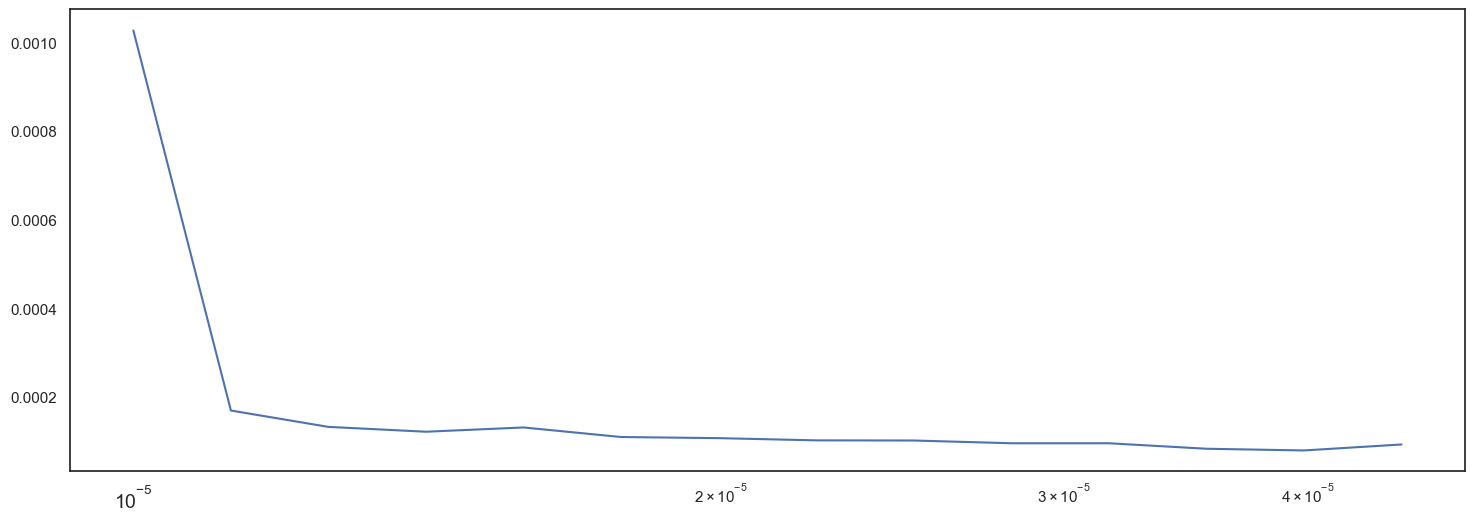

In [154]:
model_lstm = lstm_model(X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, EPOCH, BATCH_SIZE, CALLBACK, plotting=True)


In [155]:
#Set up predictions for train and validation set
y_hat_lstm = model_lstm.predict(X_val_lstm)
y_hat_train_lstm = model_lstm.predict(X_train_lstm)

#Validation Transormation
mae_lstm = mean_absolute_error(y_hat_lstm, y_hat_lstm)
real_val, pred_val = inverse_transformation(X_val_lstm, y_val_lstm, y_hat_lstm)
mae_lstm = mean_absolute_error(real_val.iloc[:, 49], pred_val.iloc[:, 49])

130/130 [==============================] - 1s 8ms/step


Text(0.5, 1.0, 'MAE for this period: 5.42')

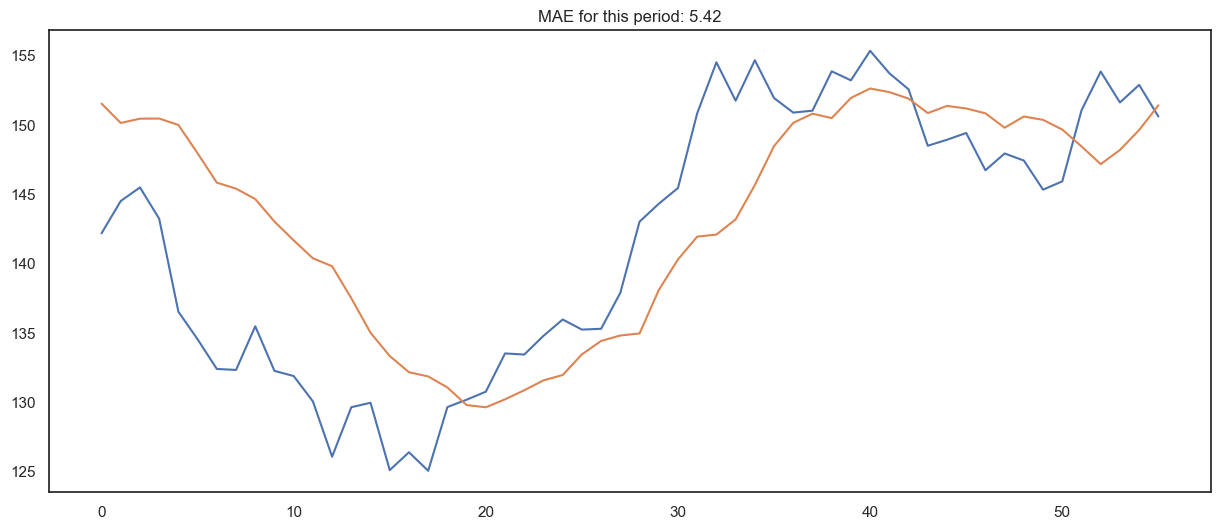

In [156]:
plt.figure(figsize=(15, 6))

plt.plot(real_val.iloc[:, 49])
plt.plot(pred_val.iloc[:, 49])

plt.title(f"MAE for this period: {round(mae_lstm, 2)}")

In [157]:
real_train, pred_train = inverse_transformation(X_train_lstm, y_train_lstm, y_hat_train_lstm)

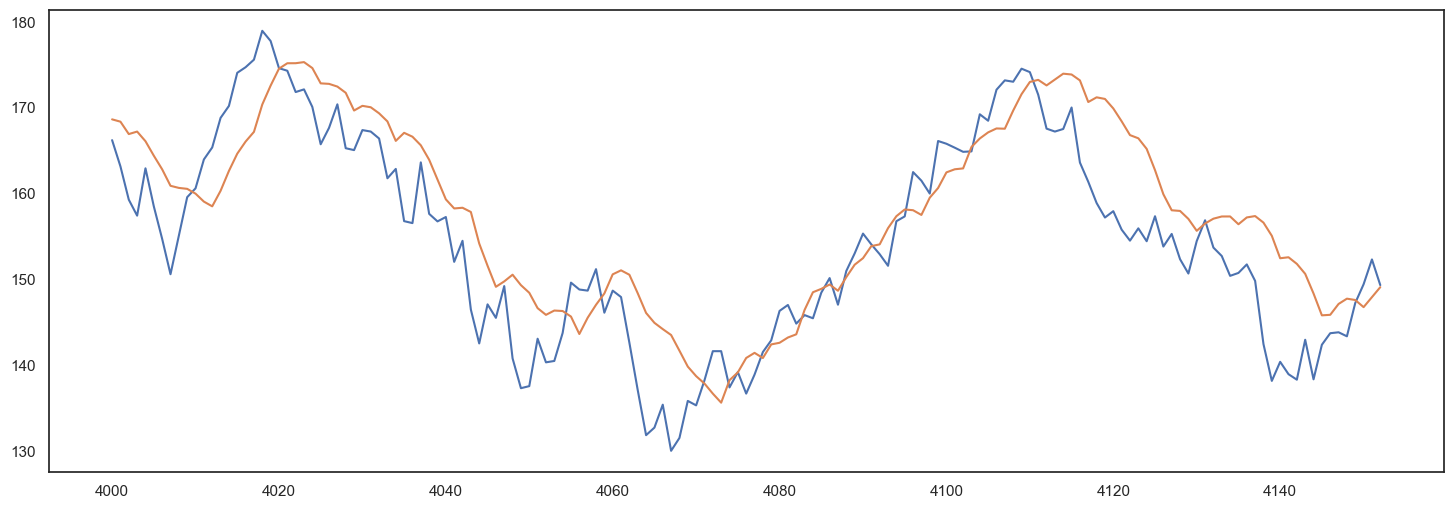

In [158]:
plt.figure(figsize=(18, 6))

plt.plot(real_train.iloc[4000:, 49])
plt.plot(pred_train.iloc[4000:, 49])

## Prediction

In [159]:
X_test_formula = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])

In [160]:
X_test_formula.shape

(30, 1, 49)

In [161]:
X_test_lstm = X_test_formula.reshape(1, X_test_formula.shape[0], X_test_formula.shape[2])

In [162]:
X_test_lstm.shape

(1, 30, 49)

In [163]:
y_hat_test_lstm = model_lstm.predict(X_test_lstm)

1/1 [==============================] - 0s 41ms/step


In [164]:
real_test, pred_test = inverse_transformation(X_test_lstm, y_test_lstm, y_hat_test_lstm)

In [165]:
y_val_lstm = np.array(real_val.iloc[-30:, 49])
y_test_lstm = np.array(real_test.iloc[:, 49])
pred_test = np.array(pred_test.iloc[-1:, 49])
mae_lstm = mean_absolute_error(real_val.iloc[:, 49], pred_val.iloc[:, 49])

For used windowed data: 30
Prediction scope for date 2023-04-25 00:00:00 / 1 days
The predicted price is 165.95$
With a spread of MAE is 5.42



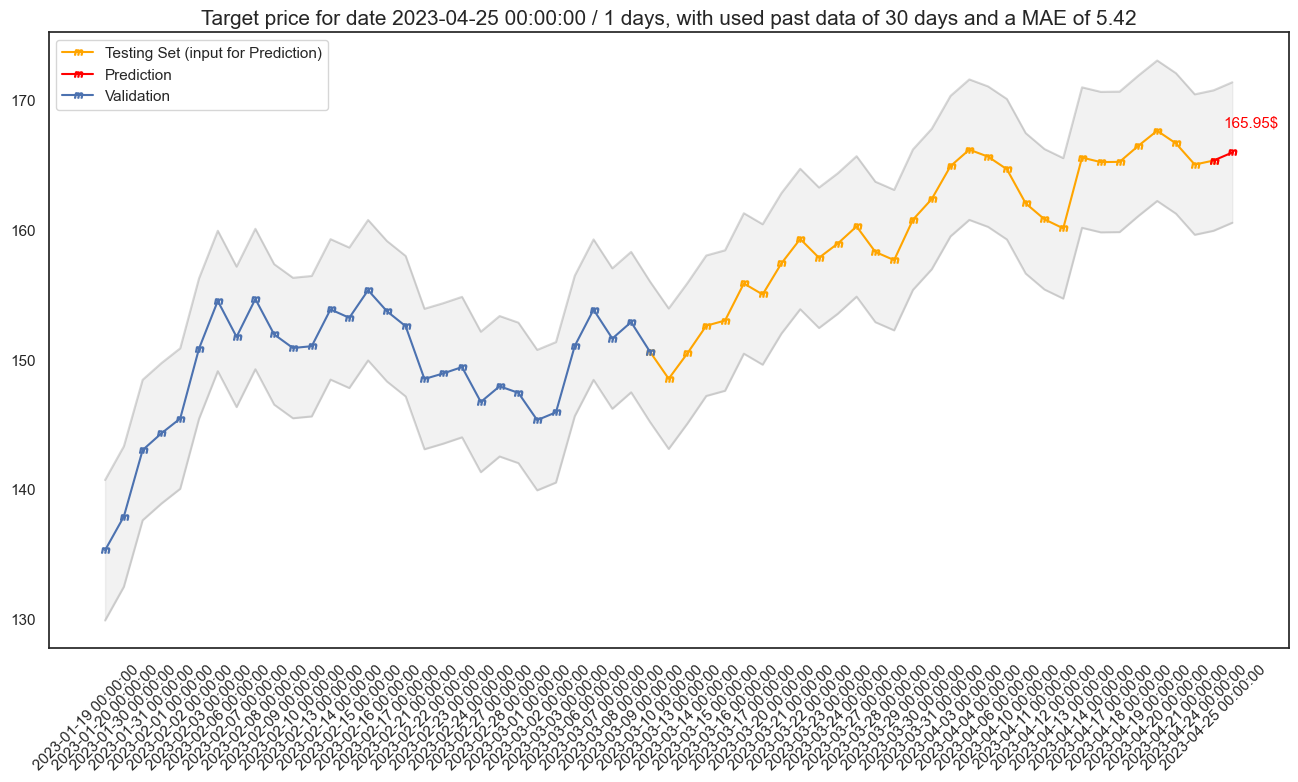


-----------------------------------------------------------------------------



In [166]:
plotting(y_val_lstm, y_test_lstm, pred_test, mae_lstm, WINDOW_LSTM, PREDICTION_SCOPE)

## Saving the Model

In [167]:
#model.save('./SVM')

In [168]:
#lstm_model = tf.keras.models.load_model("SVM")

# COMBINATION XGBoost-LSTM


In order to get the most out of the two models, good practice is to combine those two and apply a higher weight on the model which got a lower loss function (mean absolute error).

In our case we saw that the MAE of the XGBoost was lower than the one from the LSTM, therefore we will gave a higher weight on the predictions returned from the XGBoost model.

In [169]:
mae_xgboost = mae

In [170]:
xgboost_model = joblib.load("XGBoost.pkl")

In [171]:
pred_test

array([165.95159561])

In [172]:
pred_test_xgb

array([163.61356], dtype=float32)

In [173]:
scope = predictions(mae_lstm, mae_xgboost, pred_test_xgb, pred_test)

In [174]:
avg_mae = (mae_lstm + mae_xgboost)/2

In [175]:
plotting(y_val, y_test, scope, avg_mae, WINDOW, PREDICTION_SCOPE)

IndexError: index -1 is out of bounds for axis 0 with size 0